# 情感分析及数据集

In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l

##  读取数据集

首先，下载并提取路径`../data/aclImdb`中的IMDb评论数据集。


In [2]:
#@save
d2l.DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [3]:
'''
@save：d2l库中的装饰器，通常用于将函数保存到笔记中
data_dir：数据集的根目录路径
is_train：布尔值，True读取训练集，False读取测试集
'''
#@save
def read_imdb(data_dir, is_train):
    """读取IMDb评论数据集文本序列和标签"""
    # 初始化存储容器:data：存储评论文本的列表';labels：存储对应标签的列表（1=正面，0=负面）
    data, labels = [], []
    # 遍历正负样本目录;循环遍历两种标签：'pos'(正面)和'neg'(负面)
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        '''
        读取文件内容
        os.listdir()：列出目录中的所有文件
        以二进制模式('rb')打开文件，然后解码为UTF-8文本
        .replace('\n', '')：移除换行符，将多行文本合并为单行
        将清理后的评论添加到data列表
        根据文件夹名称添加标签：pos→1，neg→0
        '''
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels # (评论列表, 标签列表)
# 读取训练集数据,train_data[0]是评论列表，train_data[1]是标签列表
# 打印训练集的总样本数,用zip同时遍历前3个样本，打印标签和评论的前60个字符
train_data = read_imdb(data_dir, is_train=True)
print('训练集数目：', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('标签：', y, 'review:', x[0:60])

训练集数目： 25000
标签： 1 review: Bromwell High is a cartoon comedy. It ran at the same time a
标签： 1 review: Homelessness (or Houselessness as George Carlin stated) has 
标签： 1 review: Brilliant over-acting by Lesley Ann Warren. Best dramatic ho


## 预处理数据集

将每个单词作为一个词元，过滤掉出现不到5次的单词，我们从训练数据集中创建一个词表。


In [4]:
'''
分词处理
train_data[0]：是之前read_imdb()返回的训练评论文本列表（字符串列表）
token='word'：指定按单词分词（以空格为分隔符）
返回结果train_tokens是一个嵌套列表；每个子列表对应一条评论的分词结果
'''
train_tokens = d2l.tokenize(train_data[0], token='word')
'''
构建词汇表
train_tokens：分词后的结果作为输入
min_freq=5：只保留出现频率≥5次的单词（低频词被过滤，减少噪声和词汇表大小）
reserved_tokens=['<pad>']：添加特殊保留token：
'<pad>'：用于将不同长度的评论填充到统一长度
返回的vocab对象提供：
vocab[idx]：根据索引获取单词
vocab[token]：根据单词获取索引
vocab.freqs：词频统计
'''
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

在词元化之后，让我们绘制评论词元长度的直方图。


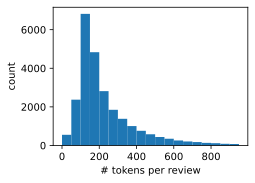

In [5]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review') # 每条评论的token数量（即评论长度）
d2l.plt.ylabel('count') # 评论的数量
'''
列表推导式：[len(line) for line in train_tokens]
计算每条评论的token数量，生成一个长度列表（如 [58,120,45,...]）
bins参数：range(0,1000,50)
定义直方图的区间范围：[0,50),[50,100),[100,150),...,[950,1000)
统计长度落在每个区间内的评论数量
末尾分号;：在Jupyter中抑制不必要的输出文本（如 <matplotlib.axes._subplots.AxesSubplot at 0x...>）,让图表显示更整洁
'''
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

正如我们所料，评论的长度各不相同。为了每次处理一小批量这样的评论，我们通过截断和填充将每个评论的长度设置为500。这类似于 `sec_machine_translation`中对机器翻译数据集的预处理步骤。


In [6]:
num_steps = 500  # 序列长度
'''
1. 遍历每条评论
train_tokens：分词后的嵌套列表，如[['this','movie',...],['i','love',...],...]
每次迭代line是一条评论的单词列表
2. vocab[line]:词元→索引转换
将单词列表转换为索引列表，例如：['this','movie']→[12,85]（数字为词汇表中的索引）
3. 截断与填充d2l.truncate_pad()：
num_steps：指定的固定长度（如500）
截断(Truncate)：若评论长度>num_steps，只保留前num_steps个词
填充(Pad)：若评论长度<num_steps，用vocab['<pad>']的索引值补全
4. 转换为张量；torch.tensor()：将处理后的索引列表转换为PyTorch张量
'''
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape) # (样本数,num_steps)

torch.Size([25000, 500])


## 创建数据迭代器

现在我们可以创建数据迭代器了。在每次迭代中，都会返回一小批量样本。


In [7]:
'''
1. 创建数据迭代器
第一个参数：(train_features, torch.tensor(train_data[1]))
train_features：形状为 (样本数, num_steps) 的特征张量
torch.tensor(train_data[1])：将标签列表转换为张量（0=负面，1=正面）
第二个参数：64——批量大小(batch size)
每次从数据集中取出64个样本进行训练
d2l.load_array：d2l工具函数，返回一个可迭代的数据加载器
内部通常使用torch.utils.data.TensorDataset+DataLoader实现

'''
train_iter = d2l.load_array((train_features,
    torch.tensor(train_data[1])), 64)
'''
2. 验证数据形状
遍历train_iter并获取第一个批次的数据
X：特征张量，形状应为 (64,num_steps)
y：标签张量，形状应为 (64,)
break：只打印第一个批次就退出循环
'''
for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
# 3. 计算批次总数
print('小批量数目：', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
小批量数目： 391


## 整合代码

最后，我们将上述步骤封装到`load_data_imdb`函数中。它返回训练和测试数据迭代器以及IMDb评论数据集的词表。


In [8]:
'''
原始文本→分词→建词表→转索引→定长处理→批量化→返回迭代器
#@save：d2l装饰器，将函数保存到笔记供后续调用
batch_size：每个小批量的样本数量（如64）
num_steps=500：每条评论固定长度（默认500个词元），用于截断或填充
'''
#@save
def load_data_imdb(batch_size, num_steps=500):
    """返回数据迭代器和IMDb评论数据集的词表"""
    # 自动下载并解压IMDb数据集
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    # read_imdb()读取训练集和测试集，返回(评论列表,标签列表)元组
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    # 分词处理:将训练集和测试集的每条评论字符串分词为单词列表
    # 结果：[['this','movie',...], ['i','love',...],...]
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    # 构建词汇表
    # min_freq=5：仅保留出现≥5次的词（过滤罕见词减少噪声）;结果：vocab对象可将词映射为索引，反之亦然
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    '''
    转换为定长张量
    词→索引：vocab[line]将单词列表转为索引列表
    截断/填充：d2l.truncate_pad将所有序列固定为500长度
    转张量：最终得到形状为 (样本数, 500) 的二维张量
    '''
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    # 创建数据迭代器
    # train_iter：训练迭代器（开启数据打乱）
    # test_iter：测试迭代器（is_train=False，不打乱顺序，便于评估）
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    # train_iter：训练数据迭代器
    # test_iter：测试数据迭代器
    # vocab：词汇表（后续可能用于词嵌入或解码）
    return train_iter, test_iter, vocab